In [82]:
import warnings
warnings.filterwarnings('ignore')

In [83]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
from matplotlib.collections import LineCollection

# 1. Load Data

In [98]:
G1 = nx.read_gpickle("Data/Graphs/G1.gpickle")
G2 = nx.read_gpickle("Data/Graphs/G2.gpickle")

# 2. Observations

## 2.1. Node Level

- Node Number

In [50]:
polarity_dict = nx.get_node_attributes(G1, "polarity")

In [51]:
np.sum(np.array(list(polarity_dict.values())) == 'anti_vaccines')

317

In [52]:
np.sum(np.array(list(polarity_dict.values())) == 'neutral')

885

In [53]:
np.sum(np.array(list(polarity_dict.values())) == 'pro_vaccines')

124

- Feb: fan size

In [54]:
fan_Feb_dict = nx.get_node_attributes(G1, "fan_size")

In [55]:
anti_fan_Feb = np.sum(np.array([v for k,v in fan_Feb_dict.items() if polarity_dict[k] == 'anti_vaccines']))
anti_fan_Feb

3914178

In [56]:
neu_fan_Feb = np.sum(np.array([v for k,v in fan_Feb_dict.items() if polarity_dict[k] == 'neutral']))
neu_fan_Feb

73433429

In [57]:
pro_fan_Feb = np.sum(np.array([v for k,v in fan_Feb_dict.items() if polarity_dict[k] == 'pro_vaccines']))
pro_fan_Feb

6808313

- Oct: fan size increase

In [58]:
fan_Oct_dict = nx.get_node_attributes(G2, "fan_size")

In [59]:
anti_fan_Oct = np.sum(np.array([v for k,v in fan_Oct_dict.items() if polarity_dict[k] == 'anti_vaccines']))
(anti_fan_Oct - anti_fan_Feb) / anti_fan_Feb

0.0623241968045398

In [60]:
neu_fan_Oct = np.sum(np.array([v for k,v in fan_Oct_dict.items() if polarity_dict[k] == 'neutral']))
(neu_fan_Oct - neu_fan_Feb) / neu_fan_Feb

0.009087700371447996

In [61]:
pro_fan_Oct = np.sum(np.array([v for k,v in fan_Oct_dict.items() if polarity_dict[k] == 'pro_vaccines']))
(pro_fan_Oct - pro_fan_Feb) / pro_fan_Feb

0.01854673837703995

## 2.2. Edge Level 

In [62]:
def choose_index(node):
    if node.startswith('a'):
        return 0
    elif node.startswith('n'):
        return 1
    else:
        return 2

### 2.2.1. Edge Number

In [63]:
def edge_table(G):
    table = np.zeros((3,3), dtype = int)
    for edge in list(G.edges):
        x, y = choose_index(edge[0]), choose_index(edge[1])
        table[x, y] += 1
    return table

- Feb

In [64]:
table1 = edge_table(G1)
print('        anti  neutral  pro')
table1

        anti  neutral  pro


array([[1015,  647,   37],
       [ 688, 1728,  401],
       [  16,  348,  283]])

- Oct: Edge Number Increase

In [65]:
table2 = edge_table(G2)
#print('        anti  neutral  pro')
#table2

In [66]:
print('        anti          neutral      pro')
(table2 - table1) / table1

        anti          neutral      pro


array([[0.42364532, 0.23338485, 0.18918919],
       [0.50436047, 0.57002315, 0.41895262],
       [0.8125    , 0.30172414, 0.40636042]])

### 2.2.2. Edge Weight

In [67]:
def weight_table(G):
    table = np.zeros((3,3))
    for edge in G.edges:
        x, y = choose_index(edge[0]), choose_index(edge[1])
        table[x, y] += G.edges[edge]['weight']
        
    return table

- Feb

In [68]:
table1 = weight_table(G1)/edge_table(G1)
print('        anti          neutral      pro')
table1

        anti          neutral      pro


array([[7.98842819e+08, 1.35462354e+10, 3.06085704e+08],
       [8.67501984e+08, 8.60336936e+09, 3.49079702e+09],
       [6.86253049e+07, 1.31008113e+10, 4.00222012e+09]])

- Oct: Average Weight Increase

In [69]:
table2 = weight_table(G2)/edge_table(G2)
#print('        anti          neutral      pro')
#table2

In [70]:
print('        anti          neutral      pro')
(table2 - table1) / table1

        anti          neutral      pro


array([[ 0.3063273 , -0.09916589,  6.31417996],
       [ 0.53463911,  0.55685178,  0.90679123],
       [80.80879862,  0.6169758 ,  0.22183066]])

## 2.3. Other

- Pages with no fans

In [71]:
counter = 0 
for node in list(G1.nodes):
    if G1.nodes[node]['fan_size'] == 0:
        counter += 1    
counter

4

In [72]:
counter = 0 
for node in list(G2.nodes):
    if G2.nodes[node]['fan_size'] == 0:
        counter += 1    
counter

10

- Self-edges

In [73]:
counter = 0
for edge in list(G1.edges):
    if edge[0] == edge[1]:
        counter += 1
counter / len(G1.edges)

0.0013558008909548712

In [74]:
counter = 0
for edge in list(G2.edges):
    if edge[0] == edge[1]:
        counter += 1
counter / len(G2.edges)

0.0010689470871191875

- Two-way edges

In [75]:
counter = 0
for edge in list(G1.edges):
    if (edge[1], edge[0]) in list(G1.edges):
        counter += 1
counter / (2 * len(G1.edges))

0.08473755568467944

In [76]:
counter = 0
for edge in list(G2.edges):
    if (edge[1], edge[0]) in list(G2.edges):
        counter += 1
counter / (2 * len(G2.edges))

0.10168359166221272

# 3. Reproduce Visualization

In [92]:
import sys
sys.path.append('Modules/bezier-curved-edges-networkx')

In [93]:
from fa2 import ForceAtlas2
from curved_edges import curved_edges

To reproduce the graphs in the paper, only weakly connected nodes in Oct will be studied.

In [94]:
def get_WCC(G, index):
    return G.subgraph(sorted(nx.weakly_connected_components(G), key=len, reverse=True)[index])

In [97]:
# Remove from graphs
node_retain = list(get_WCC(G2, 0).nodes)
node_remove = [node for node in list(G2.nodes) if node not in node_retain]

print(len(node_retain) / len(G2.nodes))

original_edges_len = len(G2.edges)

G1.remove_nodes_from(node_remove); G2.remove_nodes_from(node_remove)

print(len(G2.edges) / original_edges_len)

1.0
1.0


Node Size

In [35]:
node_size1 = np.array(list(nx.get_node_attributes(G1, 'fan_size').values()))
node_size2 = np.array(list(nx.get_node_attributes(G2, 'fan_size').values()))

In [ ]:
# rescale
node_size1 = np.log10((node_size1+10000)/5000)*150
node_size2 = np.log10((node_size2+10000)/5000)*150

Node Color

In [36]:
def find_node_color(polarity):
    if polarity == 'anti_vaccines':
        return 'red'
    elif polarity == 'neutral':
        return 'lime'
    else:
        return 'blue'

In [37]:
node_polarity = nx.get_node_attributes(G1, 'polarity').values()
node_color = []

for polarity in node_polarity:
    node_color.append(find_node_color(polarity))

Edge Colour

In [38]:
color = ['red', 'lime', 'blue']

def find_edge_color(edge_color):
    for i in range(len(edge_color)):
        edge = edge_color[i]
        if edge.startswith('a'):
            edge_color[i] = color[0]
        elif edge.startswith('n'):
            edge_color[i] = color[1]
        else: 
            edge_color[i] = color[2]
    return edge_color

In [39]:
edge_color1 = list(np.array([list(x) for x in list(G1.edges)])[:,0]); edge_color1 = find_edge_color(edge_color1)
edge_color2 = list(np.array([list(x) for x in list(G2.edges)])[:,0]); edge_color2 = find_edge_color(edge_color2)

Edge Alpha

In [40]:
edge_alpha1 = np.array(list(nx.get_edge_attributes(G1, 'weight').values()))+1; edge_alpha1 = np.log(edge_alpha1);  edge_alpha1 = edge_alpha1 / np.max(edge_alpha1)*0.5
edge_alpha2 = np.array(list(nx.get_edge_attributes(G2, 'weight').values()))+1; edge_alpha2 = np.log(edge_alpha2);  edge_alpha2 = edge_alpha2 / np.max(edge_alpha2)*0.5

- Feb

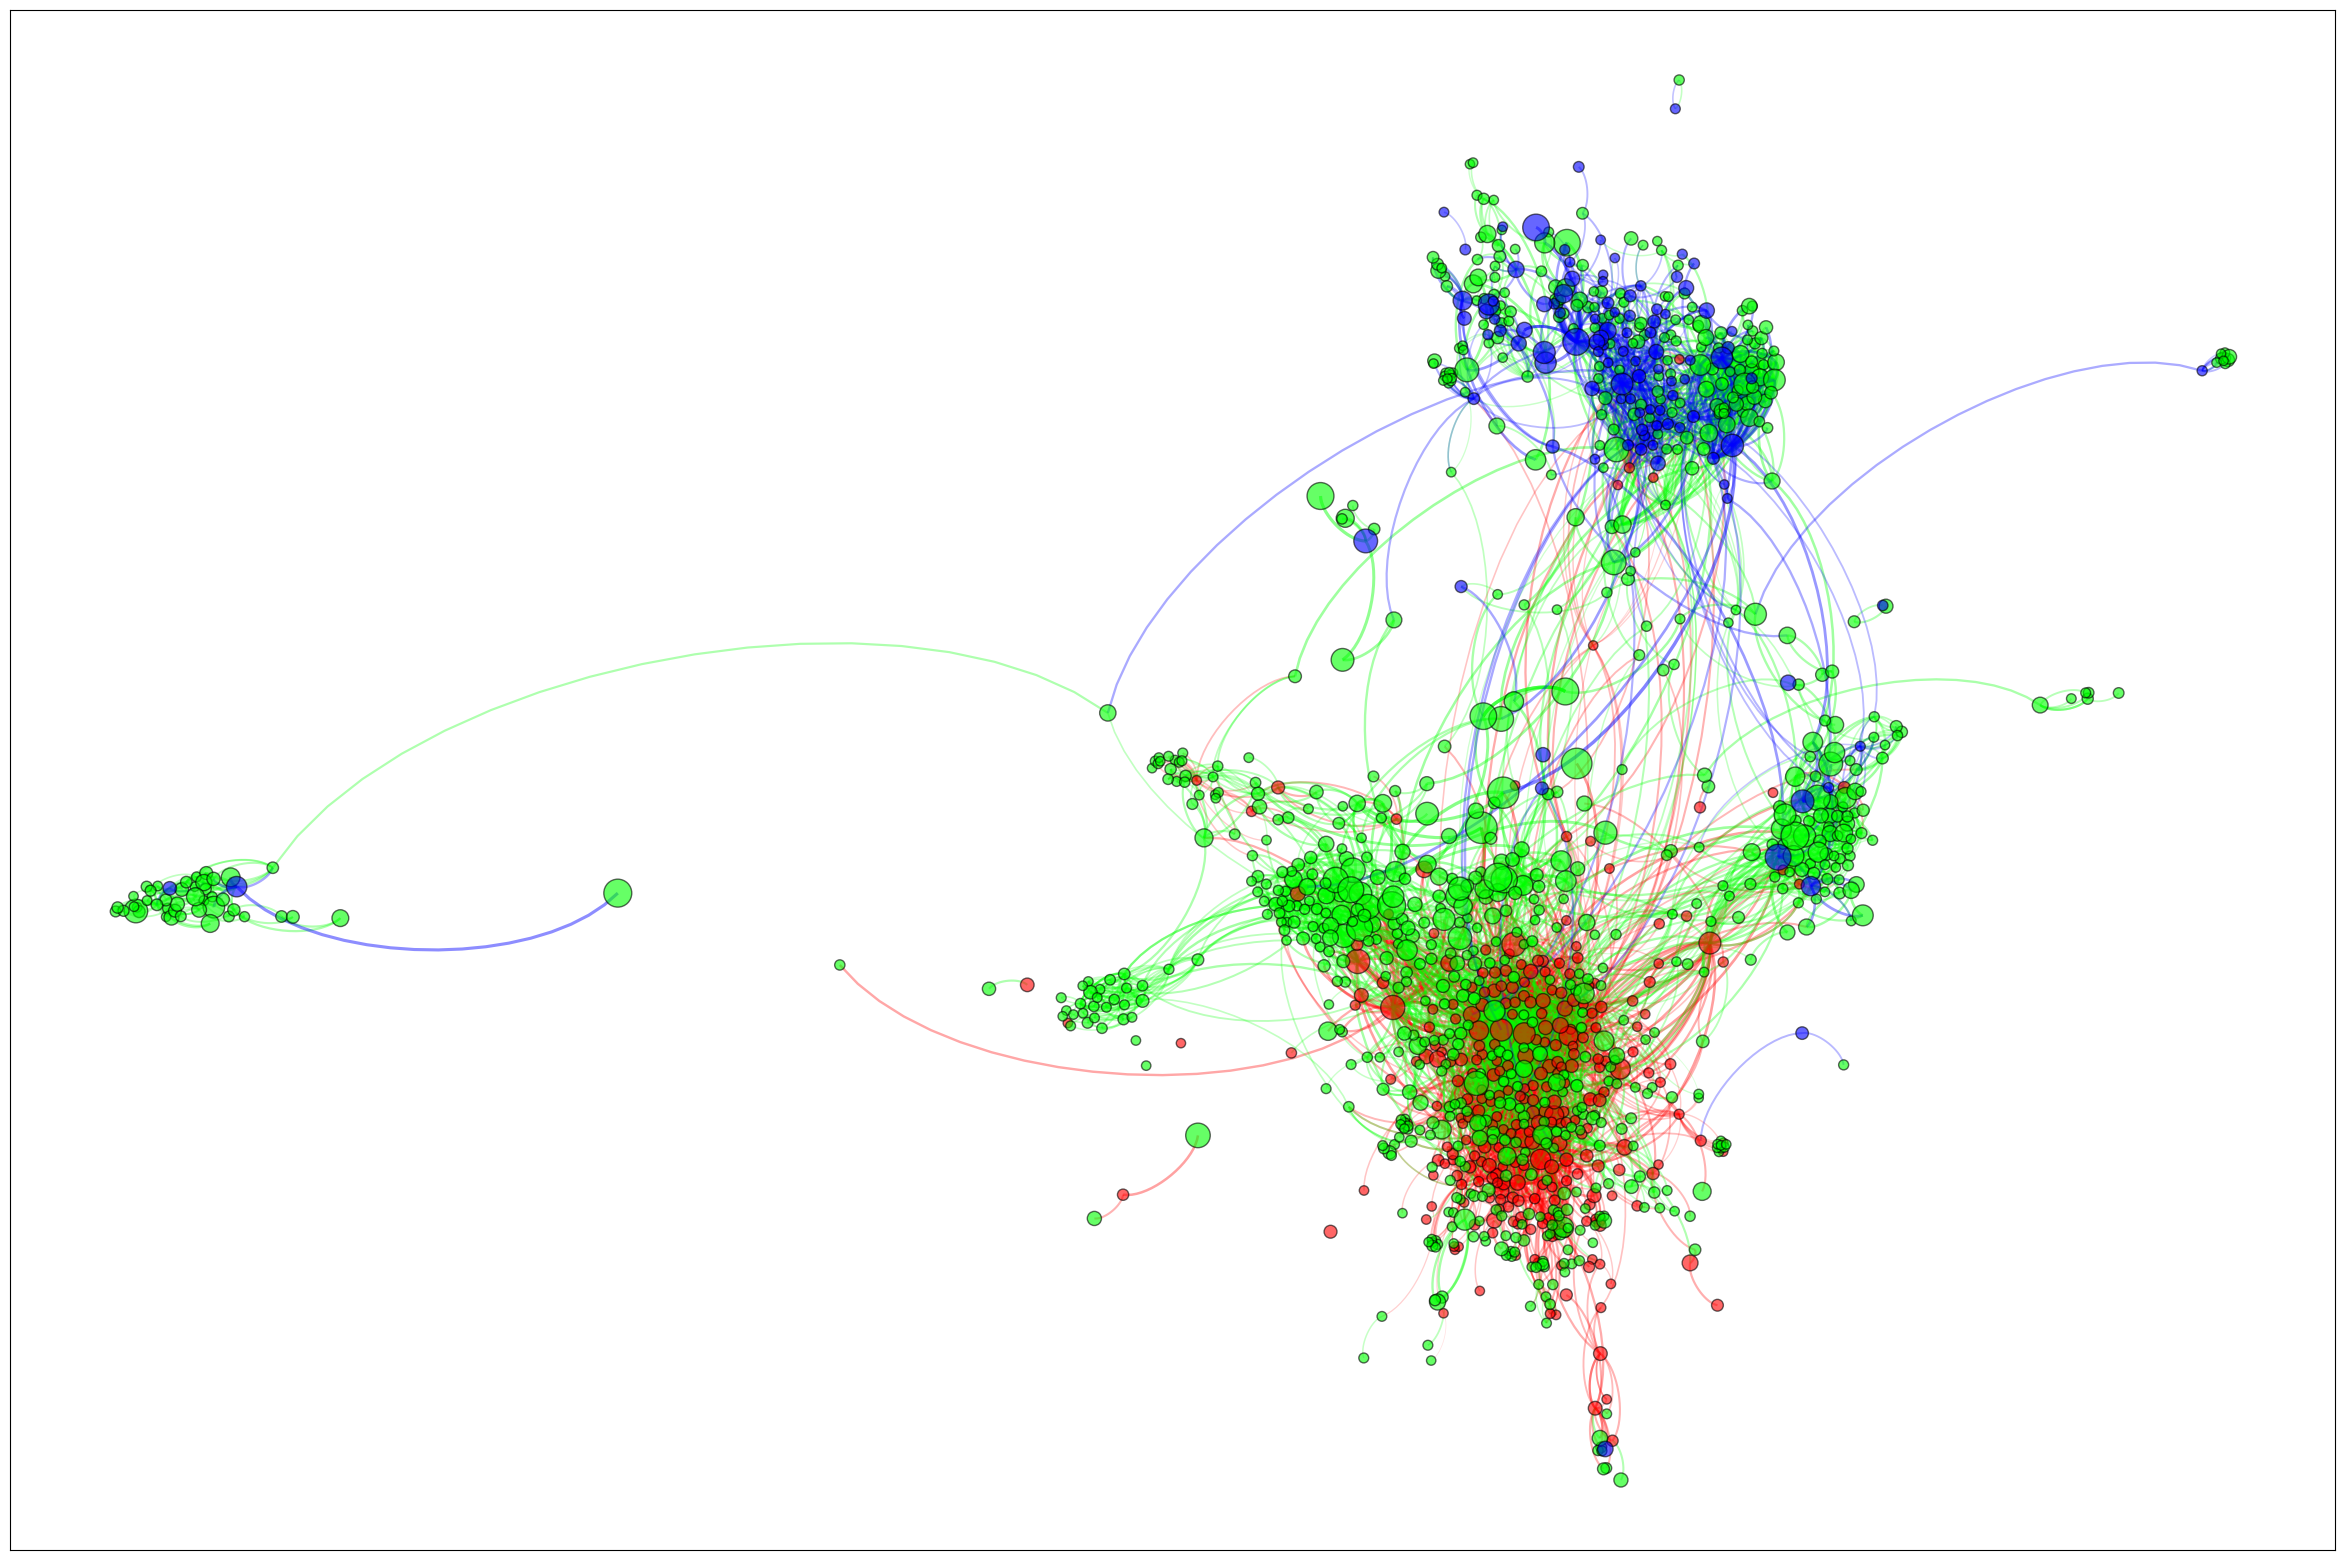

In [45]:
positions = nx.get_node_attributes(G1,'pos')

# Produce the curves
curves = curved_edges(G1, positions)
lc = LineCollection(curves, color=edge_color1, alpha=edge_alpha1, linewidth = edge_alpha1*5)

# Plot
fig1 = plt.figure(figsize=(30,20)) 
plt.gca().add_collection(lc)
plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
nx.draw_networkx_nodes(G1, positions, node_size = node_size1, node_color = node_color, alpha=0.6, edgecolors = 'k')
#plt.title('Feburary 2019', fontsize = 50)
plt.show()
fig1.savefig('Figures/Feb_Graph_Visualization.png', dpi = 300, transparent = False)

- Oct

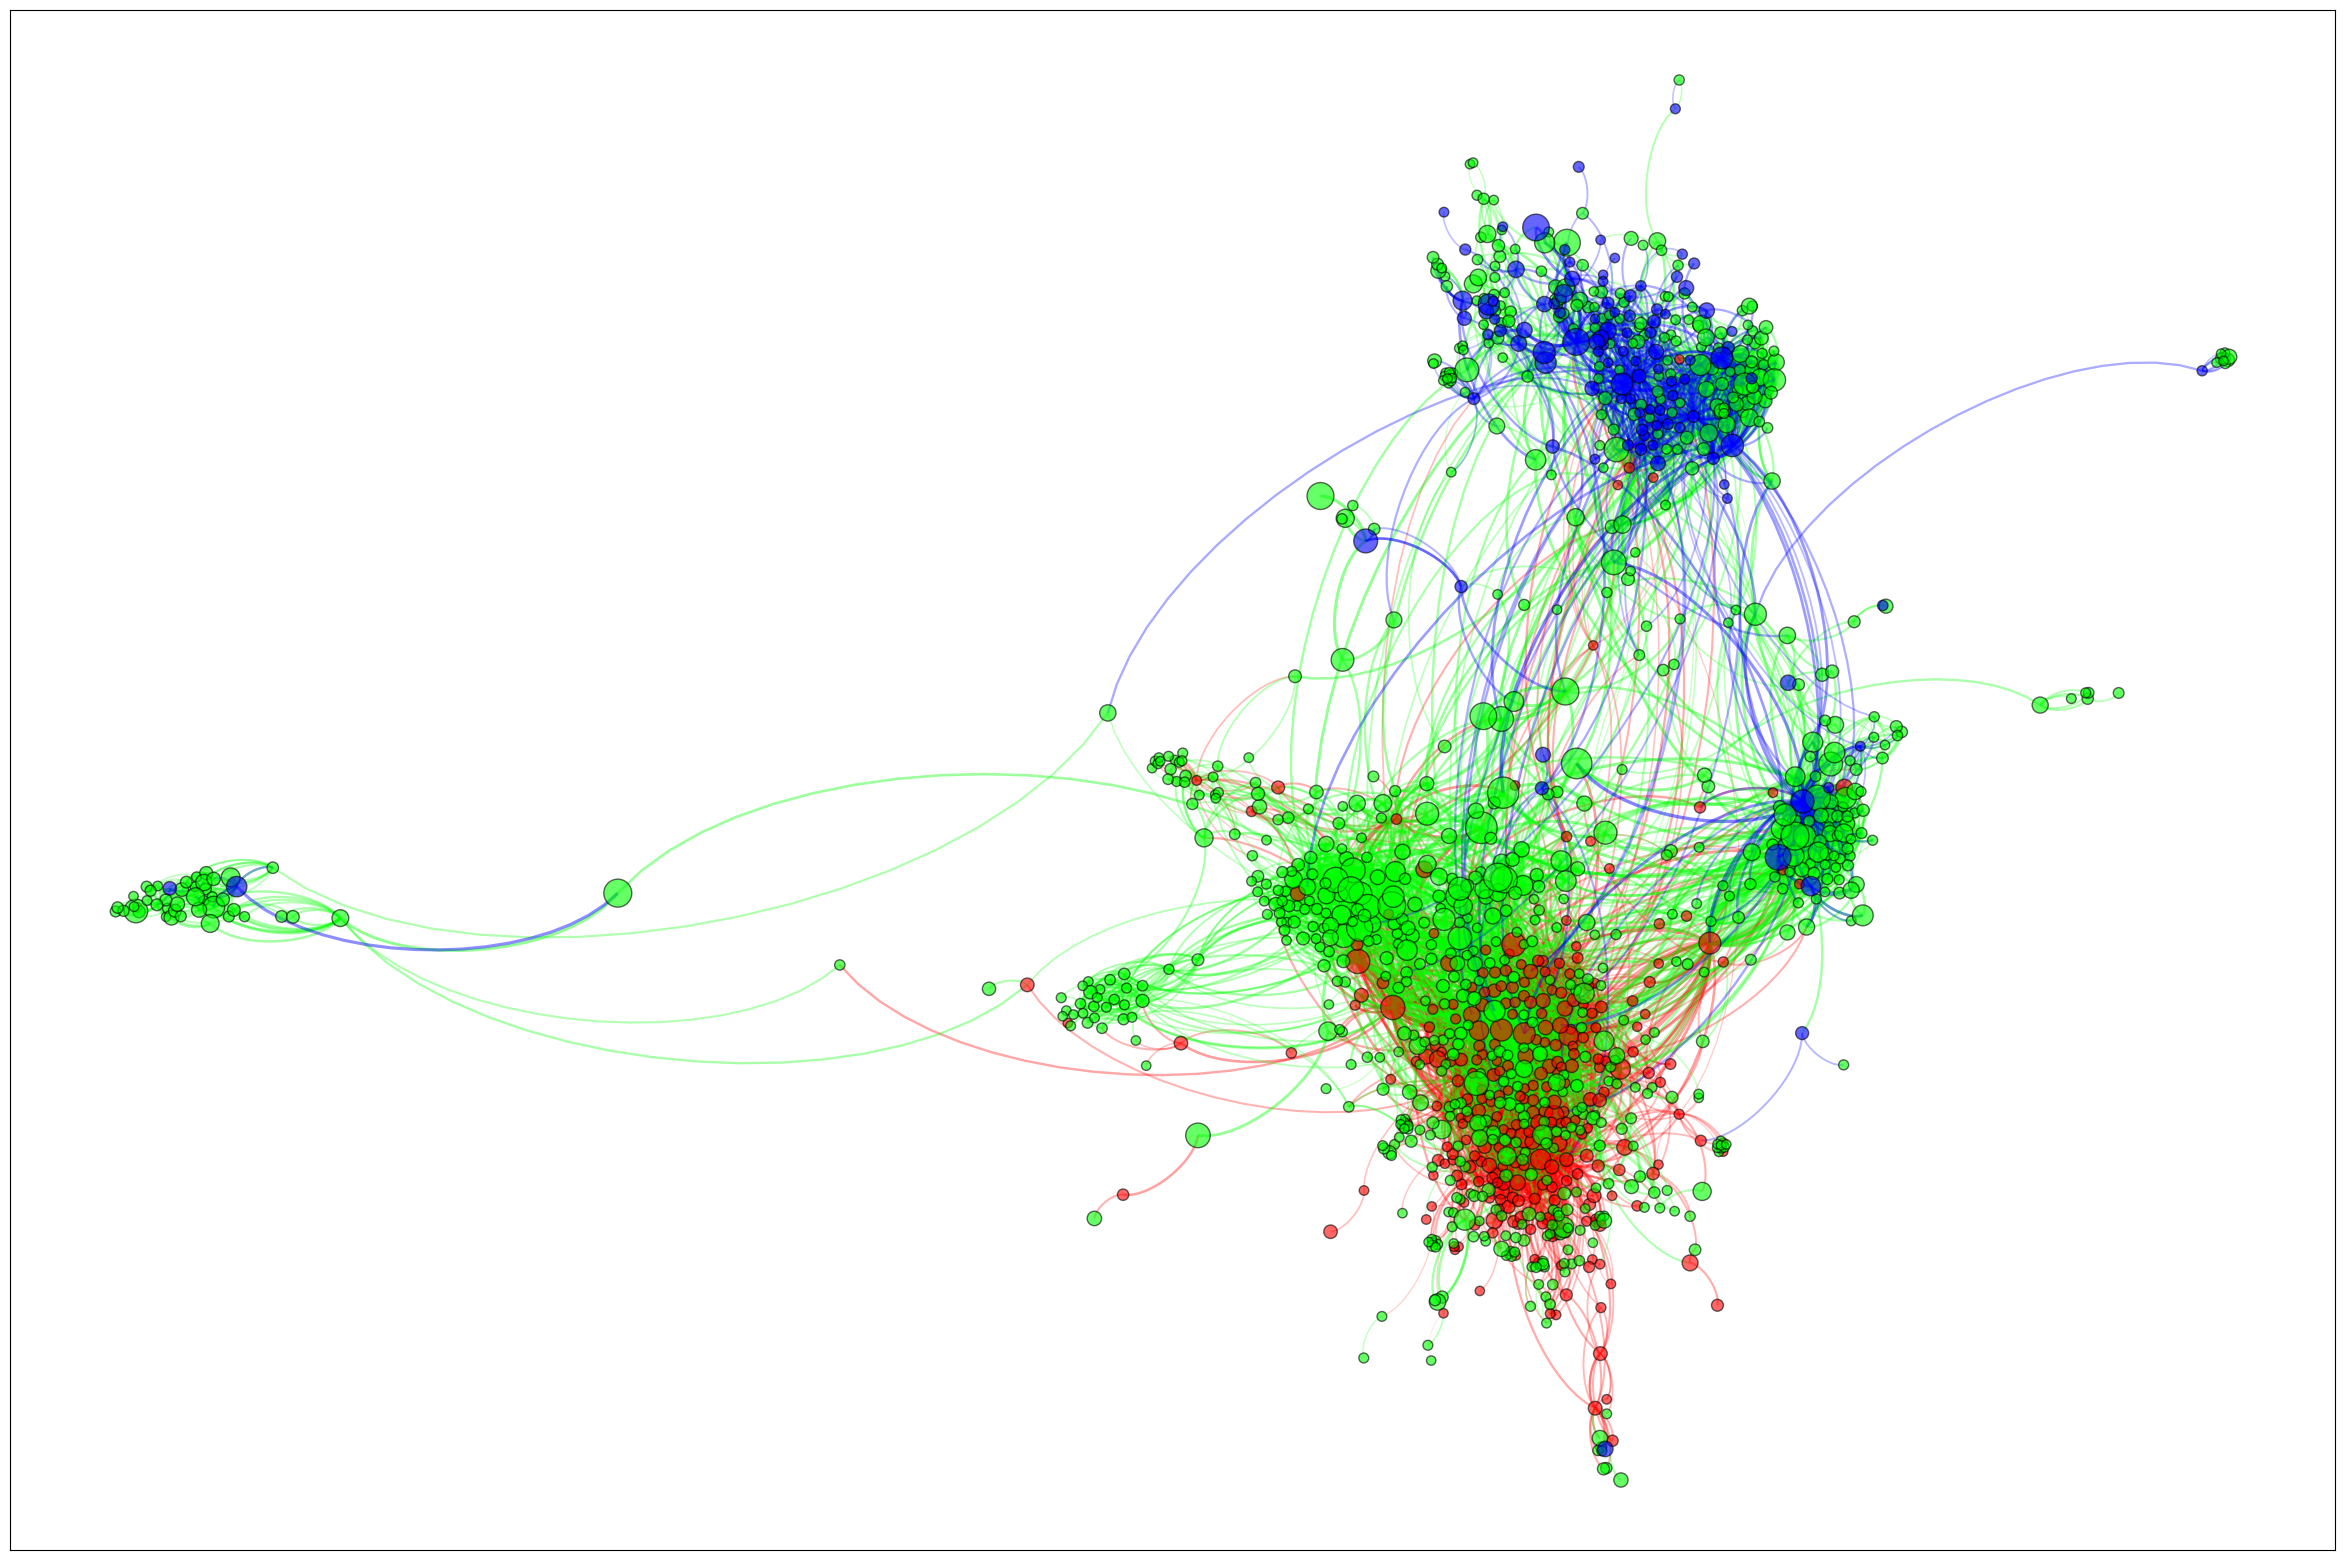

In [46]:
positions = nx.get_node_attributes(G2,'pos')

# Produce the curves
curves = curved_edges(G2, positions)
lc = LineCollection(curves, color= edge_color2, alpha=edge_alpha2, linewidth = edge_alpha2 * 5)

# Plot
fig2 = plt.figure(figsize=(30,20)) 
plt.gca().add_collection(lc)
plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
nx.draw_networkx_nodes(G2, positions, node_size = node_size2, node_color = node_color, alpha=0.6, edgecolors = 'k')
#plt.title('October 2019 - Reproduce', fontsize = 50)
plt.show()
fig2.savefig('Figures/Oct_Graph_Visualization.png', dpi = 300, transparent = False)